<a href="https://colab.research.google.com/github/hkaido0718/SupportRestriction/blob/main/ExposureMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exposure Map
In the empirical application, we specified the following exposure map:
\begin{align}
D_i(z)=\begin{cases}
3& \text{ if }z_i=SIA\\
2& \text{ if }z_i=SIP\\
1& \text{ if }z_i=C, z_{-i}\in \{SIA,SIP\}\\
0& \text{ if }z_i=C,z_{-i}=C.
\end{cases}
\end{align}
We now test the assumption that the exposure level determines the outcome:
\begin{align}
D_i(z)=D_i(z')~\Rightarrow~Y_i(z)=Y_i(z').
\end{align}


In [1]:
!git clone https://github.com/hkaido0718/SupportRestriction.git

Cloning into 'SupportRestriction'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 28 (delta 11), reused 5 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 441.54 KiB | 2.78 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [2]:
import networkx as nx
from SupportRestriction.graph_analysis_utils import GraphAnalyzer

# Define nodes
nodes = [(y, z) for z in [("C", "C"), ("SIP", "C"), ("SIA", "C")] for y in ((0,0),(0,1),(1,0),(1,1)) ]

# Group function
group_fn = lambda node: node[1]  # group by z

def get_D(z):
    D = []
    for i in [0, 1]:
        if z[i] == "SIA":
            D.append(3)
        elif z[i] == "SIP":
            D.append(2)
        elif z[i] == "C":
            other = z[1 - i]
            if other in {"SIA", "SIP"}:
                D.append(1)
            else:
                D.append(0)
    return tuple(D)

def violates_exposure_map(u,v):
    y1,z1 = u
    y2,z2 = v
    D1 = get_D(z1)
    D2 = get_D(z2)
    for i in [0, 1]:
        if D1[i] == D2[i] and y1[i] != y2[i]:
            return True
    return False

# Build G using the same logic as used for clique checking
G = GraphAnalyzer.build_graph_pairwise(nodes, violates_exposure_map,group_fn)


The potential response graph is as follows.

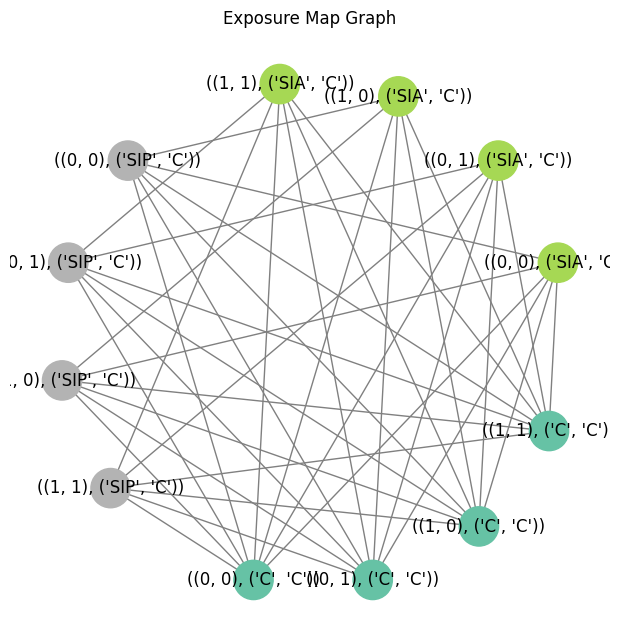

In [3]:
# Instantiate analyzer
analyzer = GraphAnalyzer(G, group_fn)

# Plot G
analyzer.plot_grouped_on_circle(title="Exposure Map Graph", node_size=800)

We can obtain the maximal independent sets and check regularity.

In [4]:
# Obtain MIS
analyzer.print_mis_excluding_single_group()
df = analyzer.save_vertex_mis_incidence("incidence_exposure.csv")

# Check Regularity
print(analyzer.is_perfect())
for row in analyzer.enumerate_cliques_and_check(violates_exposure_map):
    status = "✅" if row['satisfies_condition'] else "❌"
    print(f"{row['index']:>2}: {row['clique']} — {status}")


Total MISs (excluding single-group ones): 2

1: [((0, 0), ('SIP', 'C')), ((0, 1), ('SIA', 'C')), ((1, 0), ('SIP', 'C')), ((1, 1), ('SIA', 'C'))]
2: [((0, 0), ('SIA', 'C')), ((0, 1), ('SIP', 'C')), ((1, 0), ('SIA', 'C')), ((1, 1), ('SIP', 'C'))]
True
 1: [((0, 1), ('C', 'C')), ((0, 1), ('SIA', 'C')), ((1, 1), ('SIP', 'C'))] — ✅
 2: [((0, 1), ('C', 'C')), ((0, 1), ('SIA', 'C')), ((0, 1), ('SIP', 'C'))] — ✅
 3: [((0, 1), ('C', 'C')), ((1, 0), ('SIA', 'C')), ((1, 0), ('SIP', 'C'))] — ✅
 4: [((0, 0), ('SIA', 'C')), ((0, 1), ('C', 'C')), ((1, 0), ('SIP', 'C'))] — ✅
 5: [((0, 0), ('SIP', 'C')), ((0, 1), ('C', 'C')), ((1, 0), ('SIA', 'C'))] — ✅
 6: [((0, 0), ('SIA', 'C')), ((0, 0), ('SIP', 'C')), ((0, 1), ('C', 'C'))] — ✅
 7: [((0, 1), ('C', 'C')), ((1, 1), ('SIA', 'C')), ((1, 1), ('SIP', 'C'))] — ✅
 8: [((0, 1), ('C', 'C')), ((0, 1), ('SIP', 'C')), ((1, 1), ('SIA', 'C'))] — ✅
 9: [((0, 0), ('C', 'C')), ((0, 1), ('SIA', 'C')), ((1, 1), ('SIP', 'C'))] — ✅
10: [((0, 0), ('C', 'C')), ((0, 1), ('S

The sharp testable implication of the exposure map assumption is
\begin{multline}
P(Y=(0,1)\,|\,Z=(SIP,C),W)+P(Y=(1,1)\,|\,Z=(SIP,C),W)\\
+P(Y=(0,0)\,|\,Z=(SIA,C),W)+P(Y=(1,0)\,|\,Z=(SIA,C),W)\leqslant 1,
\end{multline}
and
\begin{multline}
P(Y=(0,0)\,|\,Z=(SIP,C),W)+P(Y=(1,0)\,|\,Z=(SIP,C),W)\\
+P(Y=(0,1)\,|\,Z=(SIA,C),W)+P(Y=(1,1)\,|\,Z=(SIA,C),W)\leqslant 1.
\end{multline}

Consider adding the following semimonotonicity restriction:
\begin{align}
D_i(z)\geqslant D_i(z')~\Rightarrow~Y_i(z)\leqslant Y_i(z').
\end{align}
We define a new graph based on the new set of assumptions. This removes additional edges from the graph.

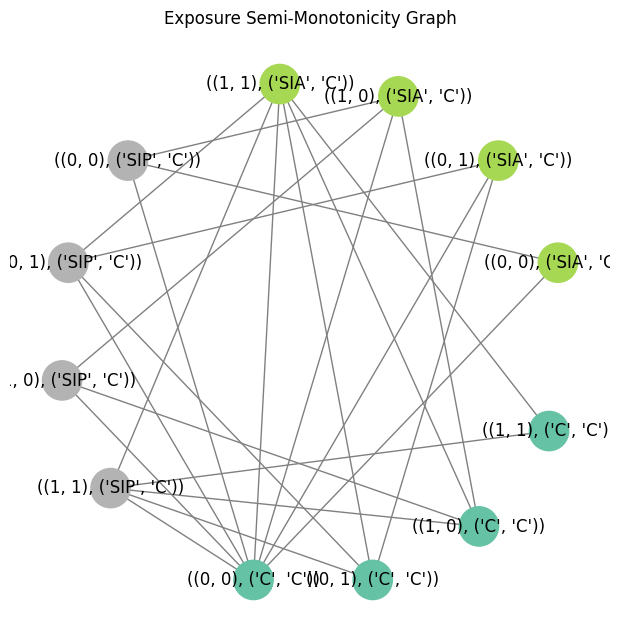

In [6]:
# Semimonotonicity
def violates_exposure_semimonotonicity(u,v):
    y1,z1 = u
    y2,z2 = v
    D1 = get_D(z1)
    D2 = get_D(z2)
    for i in [0, 1]:
        if D1[i] > D2[i] and y1[i] < y2[i]:
            return True
        if D1[i] < D2[i] and y1[i] > y2[i]:
            return True
        if D1[i] == D2[i] and y1[i] != y2[i]:
            return True
    return False


# Build G using the same logic as used for clique checking
G_semi = GraphAnalyzer.build_graph_pairwise(nodes, violates_exposure_semimonotonicity,group_fn)

# Instantiate analyzer
analyzer = GraphAnalyzer(G_semi, group_fn)

# Plot G
analyzer.plot_grouped_on_circle(title="Exposure Semi-Monotonicity Graph", node_size=800)

We now obtain sharp testable implications from the MIS and check the regularity.

In [10]:
# Obtain MIS
analyzer.print_mis_excluding_single_group()
df = analyzer.save_vertex_mis_incidence("incidence_semimonotone.csv")

# Check Regularity
print(analyzer.is_perfect())
for row in analyzer.enumerate_cliques_and_check(violates_exposure_semimonotonicity):
    status = "✅" if row['satisfies_condition'] else "❌"
    print(f"{row['index']:>2}: {row['clique']} — {status}")

Total MISs (excluding single-group ones): 22

1: [((0, 0), ('SIA', 'C')), ((0, 1), ('SIA', 'C')), ((1, 0), ('SIP', 'C')), ((1, 1), ('SIA', 'C'))]
2: [((0, 0), ('SIP', 'C')), ((0, 1), ('SIA', 'C')), ((1, 0), ('SIP', 'C')), ((1, 1), ('SIA', 'C'))]
3: [((0, 0), ('SIA', 'C')), ((0, 1), ('SIA', 'C')), ((1, 0), ('SIA', 'C')), ((1, 1), ('SIP', 'C'))]
4: [((0, 0), ('SIA', 'C')), ((0, 1), ('SIA', 'C')), ((1, 0), ('SIP', 'C')), ((1, 1), ('SIP', 'C'))]
5: [((0, 0), ('SIP', 'C')), ((0, 1), ('SIA', 'C')), ((1, 0), ('SIP', 'C')), ((1, 1), ('SIP', 'C'))]
6: [((0, 0), ('SIA', 'C')), ((0, 1), ('SIP', 'C')), ((1, 0), ('SIA', 'C')), ((1, 1), ('SIP', 'C'))]
7: [((0, 0), ('SIA', 'C')), ((0, 1), ('SIP', 'C')), ((1, 0), ('SIP', 'C')), ((1, 1), ('SIP', 'C'))]
8: [((0, 0), ('SIA', 'C')), ((0, 1), ('C', 'C')), ((1, 0), ('SIA', 'C')), ((1, 1), ('C', 'C'))]
9: [((0, 0), ('SIA', 'C')), ((0, 1), ('C', 'C')), ((1, 0), ('SIP', 'C')), ((1, 1), ('C', 'C'))]
10: [((0, 0), ('SIP', 'C')), ((0, 1), ('C', 'C')), ((1, 0), ('

We obtain 22 MISs in total. The graph is perfect, and all 12 maximal cliques are support points. Hence, the  inequalities corresponding to the MISs above give the sharp testable implication of the exposure map and semimonotonicity assumption.